# NISQ Experiment

In [44]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from qiskit import Aer
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from qiskit.providers.aer import AerSimulator
from copy import deepcopy

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from utils import *
from experiments import *
from qiskit.providers.fake_provider import FakeCasablanca
#np.set_printoptions(threshold=sys.maxsize)

In [45]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary, Operator

In [86]:
#qk.IBMQ.save_account("a9ec3c697bede976217e9ff6c5c0f19a2511ea34a225bbe10f0c74bda39de845d16fa3f7c30b47c5714e2b695aded3cfd474e7c1b33056014fab89301b83d724", overwrite=True) 
provider = qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend("ibmq_manila")

#backend = AerSimulator()

ibmqfactory.load_account:WARNING:2022-10-04 00:57:53,865: Credentials are already in use. The existing account in the session will be replaced.


In [87]:
def global_folding(circuit_target, fold=0):
    circuit = circuit_target.copy()
    circuit = qk.QuantumCircuit(circuit.num_qubits).compose(circuit)
    for i in range(fold):
        circuit.barrier()
        circuit_fold1 = circuit_target.inverse().copy()
        circuit_fold1.barrier()
        circuit_fold2 = circuit_target.copy()
        
        circuit = circuit.compose(circuit_fold1.compose(circuit_fold2))
    
    circuit.add_register(qk.ClassicalRegister(circuit.num_qubits))
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    
    return circuit

In [88]:
np.random.seed(43)
random.seed(43)
n = 3

circuit_target = variational_circuit(n, 2, 0, 2).reverse_bits()
circuit_fold0 = global_folding(circuit_target, fold=0)
circuit_fold1 = global_folding(circuit_target, fold=1)
circuit_fold2 = global_folding(circuit_target, fold=2)
circuit_fold3 = global_folding(circuit_target, fold=3)
circuit_fold4 = global_folding(circuit_target, fold=4)
circuit_fold5 = global_folding(circuit_target, fold=5)

circuit_list = [circuit_fold0, circuit_fold1, circuit_fold2, circuit_fold3, circuit_fold4, circuit_fold5]

In [89]:
job = qk.execute(circuit_list, backend, shots = 20000, optimization_level = 0, seed_transpiler=42)
result = job.result()
counts_list = [result.get_counts(circuit) for circuit in circuit_list]

In [90]:
probs = counts_to_probs(counts_list).numpy()

In [91]:
pickle.dump(probs, open(f"../../data/ZNE_three_qubit.p", "wb"))  

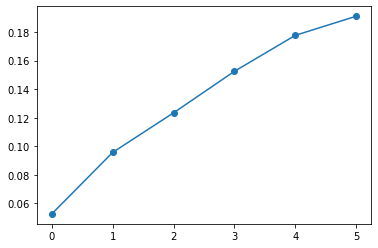

In [93]:
plt.plot(probs[:,0],"-o")